# **Importations** et chargement des données nettoyées

In [146]:
# Installation : pip install flake8 pycodestyle pycodestyle_magic
# Activate %%flake8 magic function
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


In [147]:
# %%flake8  # checking PEP8 compliance

# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import functions.functions_p5 as functions_p5

In [148]:
# Reload importation of module
import importlib
importlib.reload(functions_p5);

In [149]:
# Load file with cleaned data
data_PCA = pd.read_csv("data\cleaned\p5_data_PCA.csv")

# Set maximum number of columns
pd.set_option("display.max_columns", 1000)
display(data_PCA.head(2))
data_std.shape

,PCA_F1,PCA_F2,PCA_F3,PCA_F4,PCA_F5,PCA_F6
0,2.825938,0.205086,0.819559,-0.435504,0.410791,-0.843533
1,3.099987,0.161057,1.072663,-0.035779,-0.238990,0.200269


(98756, 6)

## **Échantillonage** aléatoire

In [150]:
import random
from random import randrange

# Set random integer (seed)
seed = random.randrange(1000)

# Initialize the seed of pseudo-random generator
random.seed(seed)
print("Seed value: ", seed)

Seed value:  983


In [151]:
# Sampling from data_PCA
X_std = data_PCA.sample(n=10000, random_state=seed)

## **Réductions dimensionnelles** (tSNE, PCA et Isomap)

In [152]:
# Applying the embedding : tSNE, PCA and Isomap

# Import libraries
from sklearn import manifold
from sklearn import decomposition

# Instanciation of the embedding

# Instanciation of t-SNE
tsne = manifold.TSNE(
            n_components=2, # for projection in a plane
            perplexity=30,
            n_iter=300,
            init='pca', # initialisation by a PCA
            random_state=0
        )
    
# Instanciation of Isomap
isomap = manifold.Isomap(
            n_components=2  # for projection in a plane
        )
        
# Instanciation of PCA
pca = decomposition.PCA(
            n_components=2 # for projection in a plane
        )

# Applying the embedding algorithm
X_tsne = tsne.fit_transform(X_std)
X_isomap = isomap.fit_transform(X_std)
X_pca = pca.fit_transform(X_std)

# **Segmentations**

## **Modèle naïf :** bissection aléatoire
Dans ce modèle naïf, nous considérons une segmentation aléatoire en deux groupes. Cela nous donne un score de référence (*'baseline'*).

### Évaluations avec coefficient de silhouette *s*

Coefficient de silhouette *s* d'une segmentation : $ s = \frac{1}{n} \sum\limits_{i=1}^n s(x^{(i)})$, avec :

* $ s(x) = \frac{b(x)-a(x)}{\max(a(x) , b(x))}$ : coefficient de silhouette du point *x*

* $ \underset{(x ∈ C_k)}{a(x)} = \frac{1}{|C_k|-1} \sum\limits_{\underset{u \neq x}{u ∈ C_k}} \mathrm{d}(u, x)$ : distance moyenne du point *x* aux autres points du même cluster

* $ b(x) = \min_{\substack{l \neq k}} \frac{1}{|C_l|} \sum\limits_{u ∈ C_l} \mathrm{d}(u, x)$ : distance moyenne du point *x* aux autres points du cluster le plus proche

In [153]:
def gini(clusters_labels):
    """Compute the Gini coefficient for a clustering.
    
    Parameters:
        - clusters_labels: pd.Series of labels of clusters for each point.
    """
    
    # Get frequencies from clusters_labels
    clusters_labels = pd.Series(clusters_labels)
    frequencies = clusters_labels.value_counts()

    # Mean absolute difference
    mad = frequencies.mad()
    
    # Mean frequency of clusters
    mean = frequencies.mean()
    
    # Gini coefficient
    gini_coeff = 0.5 * mad / mean
    
    return gini_coeff

In [154]:
# Initializing DataFrame of results
global results_df
results_df = pd.DataFrame()

def metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df):

    from sklearn import metrics
    
    # Number of clusters
    #-------------------------------------------
    nb_clusters = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    nb_clusters = int(nb_clusters)
    print('Estimated number of clusters (excluding noise): %d' % nb_clusters)
    results_df.loc[algorithm_name, 'Nb of clusters'] = nb_clusters

    # Silhouette score 
    #-------------------------------------------
    silhouette = metrics.silhouette_score(standardized_features, clusters_labels)
    print("\nSilhouette coefficient: s = {:.3f}".format(silhouette))
    print("  Notice: values closer to 1 indicate a better partition")
    results_df.loc[algorithm_name, 'Silhouette'] = silhouette

    # Gini coefficient
    #--------------------------------------------
    gini_coeff = gini(clusters_labels)
    print("\nGini coefficient: G = {:.3f}".format(gini_coeff))
    print("  Notice: values closer to 0 indicate homogenic frequencies for clusters.")
    results_df.loc[algorithm_name, 'Gini'] = gini_coeff
    
    # Sorting the pd.DataFrame of results
    results_df = results_df.sort_values('Silhouette', ascending=False)
    
    print("")
    return results_df

In [155]:
algorithm_name = 'Naïve model'
standardized_features = X_std

# Random labels (0 or 1)
clusters_labels = np.random.randint(2, size=len(standardized_features))

metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters (excluding noise): 2

Silhouette coefficient: s = 0.000
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.001
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
Naïve model,2.0,0.00018,0.0007


## **Ségmentation hiérarchique** (*hierarchical clustering*)

In [156]:
from sklearn.base import BaseEstimator
import numpy as np

class GridSearch(BaseEstimator):
    """Classe permettant d'implémenter une recherche exhaustive sur grille
    (sans validation croisée) pour les algorithmes de clustering."""
        
    # Method: init
    #------------------------------------------------------------------------------
    def __init__(self,
                estimator, # clustering algorithm to test
                param_grid, # research space for hyperparameters
                scoring=None,
                ):
        """Méthode d'initialisation prenant en entrée le modèle
        à tester et la grille de paramètres."""
        
        # getting parameters
        self.estimator = estimator
        self.param_grid = param_grid
        self.scoring = scoring
        
    # Method: fit
    #------------------------------------------------------------------------------
    def fit(self, X):
        """Méthode permettant de réaliser la recherche sur grille,
        et renvoyant le meilleur modèle trouvé, ré-entraîné sur les données."""

        # initialization of the dict of results
        self.results_ = {"scores":[],
                         "params":[],
                         "models":[],
                         "fit_times":[],
                         "nb_clusters":[],
                         "gini_coef":[],
                        }
        
        # Loading modules
        from sklearn.model_selection import ParameterGrid
        
        # iterating upon all combinations of parameters
        for param_combination in ParameterGrid(param_grid):

            # instanciation of the model with selected parameters
            model = self.estimator(**param_combination)
          
            # Measuring training time while fitting the model on the data
            time_train = %timeit -n1 -r1 -o -q model.fit(X)
            time_train = time_train.average

            # Scoring the model
            if not self.scoring: # if scoring parameter not defined
                model_score = model.score(X)       
            else:  # if scoring parameter is defined
                try:
                    labels = model.labels_
                    model_score = self.scoring(X, labels)
                except:
                    model_score = np.nan
            
            # Computing number of clusters, excluding noise (#-1)
            nb_clusters = len(set(model.labels_)) - (1 if -1 in clusters_labels else 0)
            nb_clusters = int(nb_clusters)
            
            # Computing Gini coefficient
            gini_coeff = gini(model.labels_)

            # saving results, parameters and models in a dict
            self.results_["scores"].append(model_score) # scores
            self.results_["params"].append(param_combination) # parameters
            self.results_["models"].append(model) # trained models
            self.results_["fit_times"].append(time_train) # training time
            self.results_["gini_coef"].append(gini_coeff) # Gini coefficient
            self.results_["nb_clusters"].append(nb_clusters) # number of clusters
                            
        # Selecting best model (assumes that 'greater is better')
        best_model_index, best_score = None, None # initialisation
        for index, score in enumerate(self.results_["scores"]): # iterating over scores
            
            # initialisation
            if not best_score:
                best_score = score
                best_model_index = index
                
            # if score is better than current best_score 
            if score > best_score:
                # update the current best_score and current best_model_index
                best_score = score
                best_model_index = index       
        
        # Update attributes of the instance
        self.best_score_ = self.results_["scores"][best_model_index]
        self.best_params_ = self.results_["params"][best_model_index]
        self.best_estimator_ = self.results_["models"][best_model_index]
        self.best_index_ = best_model_index
        self.refit_time_ = self.results_["fit_times"][best_model_index]

        return self

    # Method: predict
    #------------------------------------------------------------------------------
    def predict(self, X_test):
        """Méthode permettant de réaliser les prédictions sur le jeu de test, 
        en utilisant le meilleur modèle trouvé avec la méthode .fit 
        entraîné sur le jeu d'entraînement complet."""
        
        # use the .predict method of the estimator on the best model
        return self.best_model.predict(X_test)

### Définition de l'espace de recherche

In [157]:
# Definition of the search space for hyperparameters
param_grid = [
    {'n_clusters': range(4,10),  # number of clusters to find
    'linkage': ['complete', 'average', 'single'],  # linkage criterion to use
    'affinity': ['euclidean', 'manhattan', 'cosine'],},  # Metric used to compute the linkage
    
    {'n_clusters': range(4,10),  # number of clusters to find
    'linkage': ['ward'],  # linkage criterion to use
    }
]

### Sélection des hyper-paramètres

In [158]:
# importing modules
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
hierarchy_search = GridSearch(
    estimator=AgglomerativeClustering,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
hierarchy_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", hierarchy_search.best_params_)
print("Best Silhouette score:", hierarchy_search.best_score_)
print("Training time:", hierarchy_search.refit_time_)

Best hyperparameters: {'affinity': 'euclidean', 'linkage': 'complete', 'n_clusters': 4}
Best Silhouette score: 0.6632658641991308
Training time: 4.3179448000000775


In [159]:
pd.DataFrame(hierarchy_search.results_)

,scores,params,models,fit_times,nb_clusters,gini_coef
0,0.663266,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",4.317945,4,0.742800
1,0.208624,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",4.169283,5,0.592800
2,0.206755,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",4.105910,6,0.659467
3,0.167524,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.943036,7,0.674086
4,0.112343,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.789312,8,0.584800
5,0.100905,"{'affinity': 'euclidean', 'linkage': 'complete...","AgglomerativeClustering(affinity='euclidean', ...",3.733925,9,0.626467
6,0.663266,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.994296,4,0.742800
7,0.327627,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",4.123167,5,0.786000
8,0.325780,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",4.129352,6,0.819333
9,0.325610,"{'affinity': 'euclidean', 'linkage': 'average'...","AgglomerativeClustering(affinity='euclidean', ...",3.919506,7,0.843143


### Dendrogramme avec Scipy


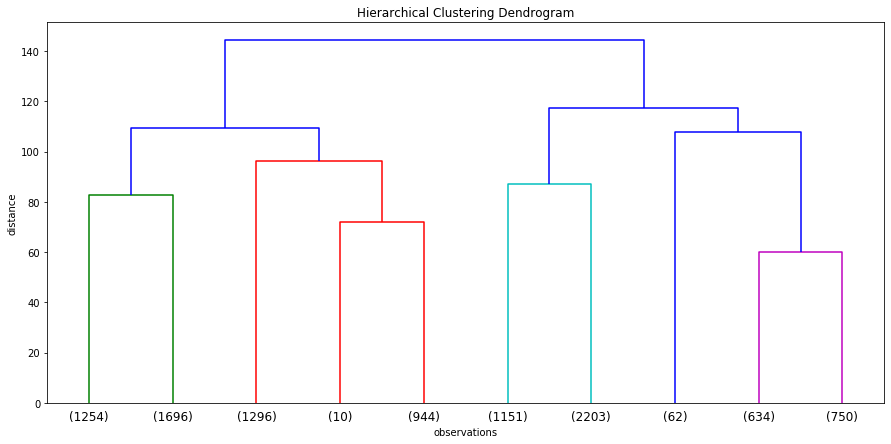

In [160]:
def plot_dendrogram(Z, labels=[], p=10):
    """This function plots the dendogram.
    Parameters:
    ----------
        - Z : linkage. Ex: Z = linkage(X_std, 'ward')
        - labels : names of the points
        - p : numbers of clusters to stop"""
    
    from scipy.cluster.hierarchy import dendrogram
    
    plt.figure(figsize=(15,7))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('observations')
    plt.ylabel('distance')
    dendrogram(
        Z,
        p=p,
        # labels = names,
        truncate_mode = "lastp"
    )
    plt.show()

    
# Clustering hiérarchique (critère de Ward)
from scipy.cluster.hierarchy import linkage
Z = linkage(X_std, 'ward')

# number of clusters for truncating dendogram
p = 10

# plotting the dendogram
plot_dendrogram(Z, p=p)

### Visualisation par réduction dimensionnelle

In [161]:
def plot_clusters(standardized_features, clusters_labels, embedding_algo='tSNE', ax=None):
    """
    Arguments:
    ---------
    embedding_algo: 'tSNE' or 'PCA' or 'Isomap'
    """
    
    # Applying the embedding
    #-----------------
    # Import libraries
    from sklearn import manifold
    from sklearn import decomposition
    
    # Instanciation of the embedding
    if embedding_algo == 'tSNE':
        X_projected = X_tsne
    
    elif embedding_algo == 'Isomap':
        X_projected = X_isomap
        
    elif embedding_algo == 'PCA':
        X_projected = X_pca
    
    # Plotting the Isomap embedding
    #-----------------------------
    
    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca() # ax = ax or plt.gca() # 'a or b' instruction returns first True value   
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(12)
        plt.gcf().set_figheight(7)
    
    # Definitions of axis boundaries
    ax.set_xlim(X_projected[:,0].min()*1.1, X_projected[:,0].max()*1.1)
    ax.set_ylim(X_projected[:,1].min()*1.1, X_projected[:,1].max()*1.1)

    # Properties of the axes
    ax.set_title(embedding_algo, fontsize=20)
    
    if embedding_algo == 'PCA': 
        # Names of x- and y- axis, with percentage of explained variance  
        ax.set_xlabel('First component ({}%)'.format(round(100*pca.explained_variance_ratio_[0],1)))
        ax.set_ylabel('Second component ({}%)'.format(round(100*pca.explained_variance_ratio_[1],1)))
    else:
        ax.set_xlabel('First component')
        ax.set_ylabel('Second component')
        
    # Setting color
    NB_CLUSTERS = len(set(clusters_labels)) - (1 if -1 in clusters_labels else 0)
    color = clusters_labels / NB_CLUSTERS
    
    # Setting color to black for noise points
    # color = pd.Series(clusters_labels / NB_CLUSTERS).astype('object')
    # color = color.map(lambda x: x if x != (-1 / NB_CLUSTERS) else 'black')
    
    # Plotting the scatter plot
    ax.scatter(
            X_projected[:,0], # x-coordinate
            X_projected[:,1], # y-coordinate
            c=color, # base for coloration of points
            cmap=plt.cm.get_cmap('Set1'), # colormap
            )

In [162]:
def clustering_plots(algorithm_name, standardized_features, clusters_labels):

    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec

    fig = plt.figure()

    # Set properties of the figure
    fig.set_figheight(6)
    fig.set_figwidth(23)
    fig.suptitle('Visualisation of clustering with {}'.format(algorithm_name), fontsize=20)

    # Set the geometry of the grid of subplots
    gs = gridspec.GridSpec(nrows=1, ncols=3,)

    # Initialize axes and set position (left to right, top to bottom)
    # Use sharex or sharey parameter for sharing axis
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])

    # Filling the axes
    plot_clusters(standardized_features, clusters_labels, embedding_algo='tSNE', ax=ax1)
    plot_clusters(standardized_features, clusters_labels, embedding_algo='PCA', ax=ax2)
    plot_clusters(standardized_features, clusters_labels, embedding_algo='Isomap', ax=ax3)

    # Automatically adjusts subplots params to fit the figure
    gs.tight_layout(fig, rect=[0, 0, 1, 0.96])
    
    fig.savefig('plots/embedding.png');

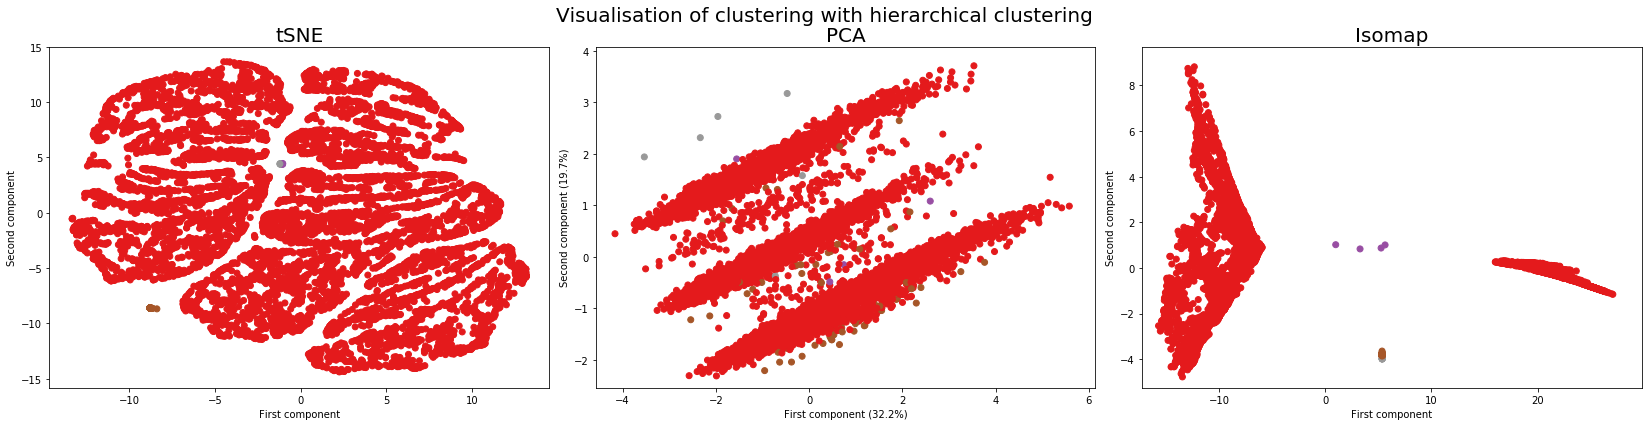

In [163]:
# Setup for call to the clustering_plots function
algorithm_name = 'hierarchical clustering'
standardized_features = X_std
clusters_labels = hierarchy_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [164]:
# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters (excluding noise): 4

Silhouette coefficient: s = 0.663
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.743
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.663266,0.7428
Naïve model,2.0,0.000180,0.0007


## ***k-MEANS***

### Définition de l'espace de recherche des hyper-paramètres

In [165]:
# Definition of the search space for hyperparameters
param_grid = {
    "n_clusters":  range(2, 11), # number of clusters
}

### Application de l'algorithme et ajustement des hyper-paramètres

In [166]:
# importing modules
from sklearn import cluster
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
kmeans_search = GridSearch(
    estimator=cluster.MiniBatchKMeans,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
kmeans_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", kmeans_search.best_params_)
print("Best Silhouette score:", kmeans_search.best_score_)
print("Training time:", kmeans_search.refit_time_)

Best hyperparameters: {'n_clusters': 10}
Best Silhouette score: 0.24648558083012204
Training time: 0.048422600000321836


### Influence des hyper-paramètres

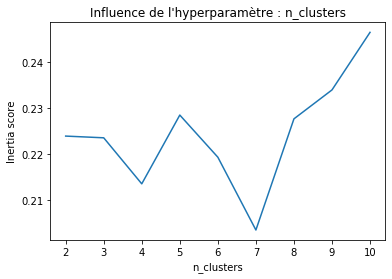

In [167]:
# Getting the list of parameters and list of scores
n_clusters_list = [kmeans_search.results_['params'][i]['n_clusters'] \
                   for i in range(len(kmeans_search.results_['params']))]
scores_list = kmeans_search.results_['scores']

# Plotting the influence of the single hyperparameter
x = n_clusters_list
y = scores_list
plt.xlabel("n_clusters")
plt.ylabel("Inertia score")
plt.title("Influence de l'hyperparamètre : n_clusters")
plt.plot(x, y);

### Réduction dimensionnelle et visualisation

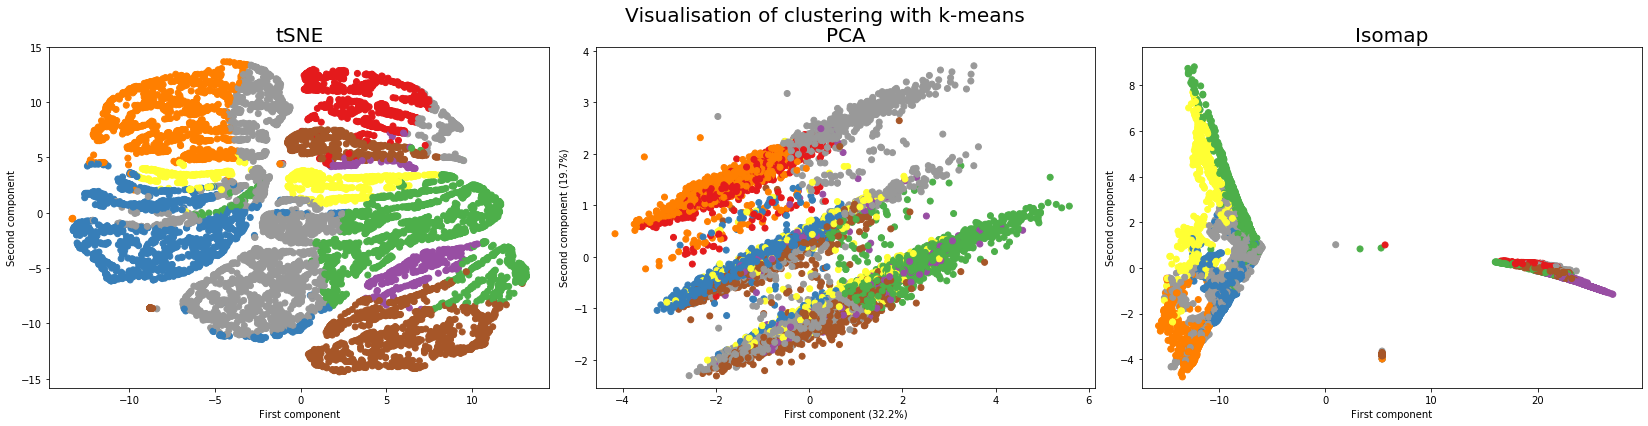

In [168]:
# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

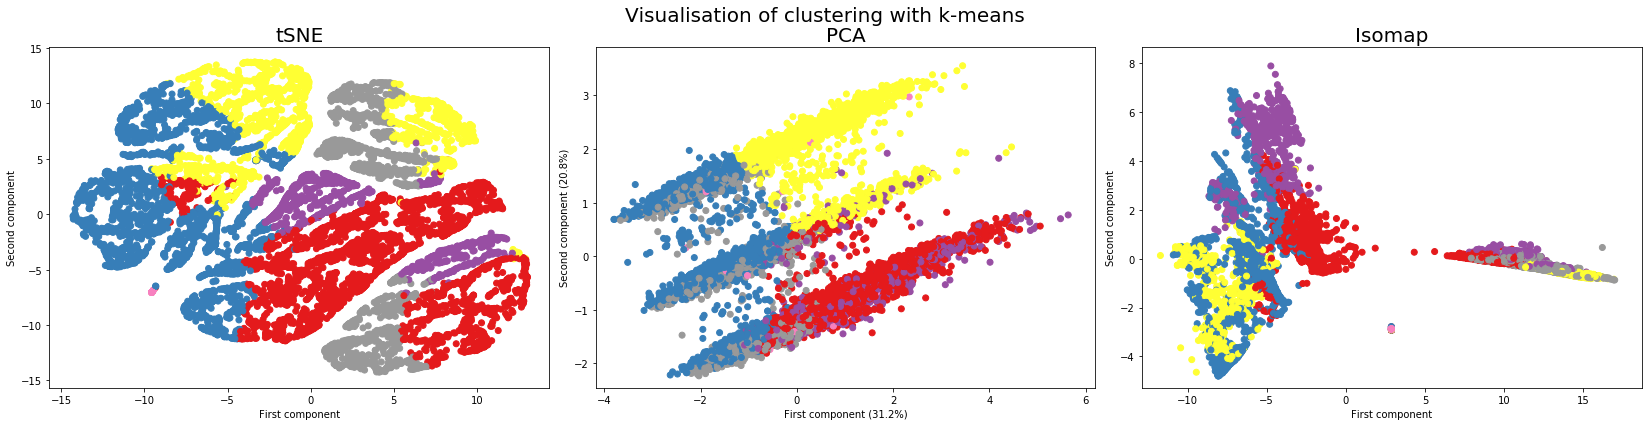

In [24]:
kmeans = cluster.MiniBatchKMeans(n_clusters=6, random_state=seed)
kmeans.fit(X_std)

# Setup for call to the clustering_plots function
algorithm_name = 'k-means'
standardized_features = X_std
clusters_labels = kmeans.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [25]:
# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters (excluding noise): 6

Silhouette coefficient: s = 0.228
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.243
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.675259,0.7446
k-means,6.0,0.227800,0.2425
Naïve model,2.0,0.000058,0.0007


## **DBSCAN**
*Density-Based Spatial Clustering of Applications with Noise*

### Application de l'algorithme

In [27]:
# Definition of the search space for hyperparameters
param_grid = {
    'eps': [0.05, 0.1, 0.25, 0.5, 1, 2, 4],  # maximum distance that define neighborhood
    'min_samples': range(5,10), # number of neighbors to be considered as a core point
    'n_jobs': [-1]
}

In [28]:
# importing modules
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
dbscan_search = GridSearch(
    estimator=DBSCAN,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
dbscan_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", dbscan_search.best_params_)
print("Best Silhouette score:", dbscan_search.best_score_)
print("Training time:", dbscan_search.refit_time_)

Best hyperparameters: {'eps': 4, 'min_samples': 5, 'n_jobs': -1}
Best Silhouette score: 0.6752585287748161
Training time: 2.2044539999999415


### Influence des hyperparamètres

In [29]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="left",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    import matplotlib
    
    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

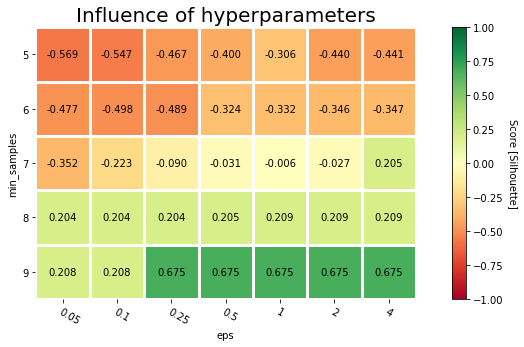

In [30]:
# Setting labels for parameters
param_1 = [0.05, 0.1, 0.25, 0.5, 1, 2, 4] # 'eps'
param_2 = range(5,10) # 'min_samples'
nb_cols = len(param_1)
nb_rows = len(param_2)

# Getting the list of scores as a np.ndarray
scores = dbscan_search.results_['scores']
scores = np.asarray(scores)
scores = scores.reshape(nb_rows, nb_cols)

# Setting the plot
fig, ax = plt.subplots(figsize=(13,5))

# from matplotlib import colors
# colors.DivergingNorm(vmin=-1., vcenter=0., vmax=1.)

im, cbar = heatmap(scores, col_labels=param_1, row_labels=param_2, ax=ax,
                   cmap="RdYlGn", cbarlabel="Score [Silhouette]", vmin=-1, vmax=1)
texts = annotate_heatmap(im, valfmt="{x:.3f}")

plt.title("Influence of hyperparameters", fontsize=20)
plt.xlabel('eps')
plt.ylabel('min_samples')

# fig.tight_layout()
plt.show()

In [31]:
pd.DataFrame(dbscan_search.results_)

,scores,params,models,fit_times,nb_clusters,gini_coef
0,-0.569122,"{'eps': 0.05, 'min_samples': 5, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",0.125135,92,0.928430
1,-0.547448,"{'eps': 0.05, 'min_samples': 6, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",0.116339,38,0.943884
2,-0.466515,"{'eps': 0.05, 'min_samples': 7, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",0.134449,20,0.934800
3,-0.400038,"{'eps': 0.05, 'min_samples': 8, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",0.133761,9,0.881389
4,-0.306243,"{'eps': 0.05, 'min_samples': 9, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.05, leaf_size=3...",0.120170,5,0.795800
5,-0.439913,"{'eps': 0.1, 'min_samples': 5, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",0.125409,229,0.777199
6,-0.440775,"{'eps': 0.1, 'min_samples': 6, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",0.117597,142,0.803446
7,-0.477037,"{'eps': 0.1, 'min_samples': 7, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",0.120290,103,0.833274
8,-0.497585,"{'eps': 0.1, 'min_samples': 8, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",0.115762,77,0.847926
9,-0.488562,"{'eps': 0.1, 'min_samples': 9, 'n_jobs': -1}","DBSCAN(algorithm='auto', eps=0.1, leaf_size=30...",0.117209,50,0.865200


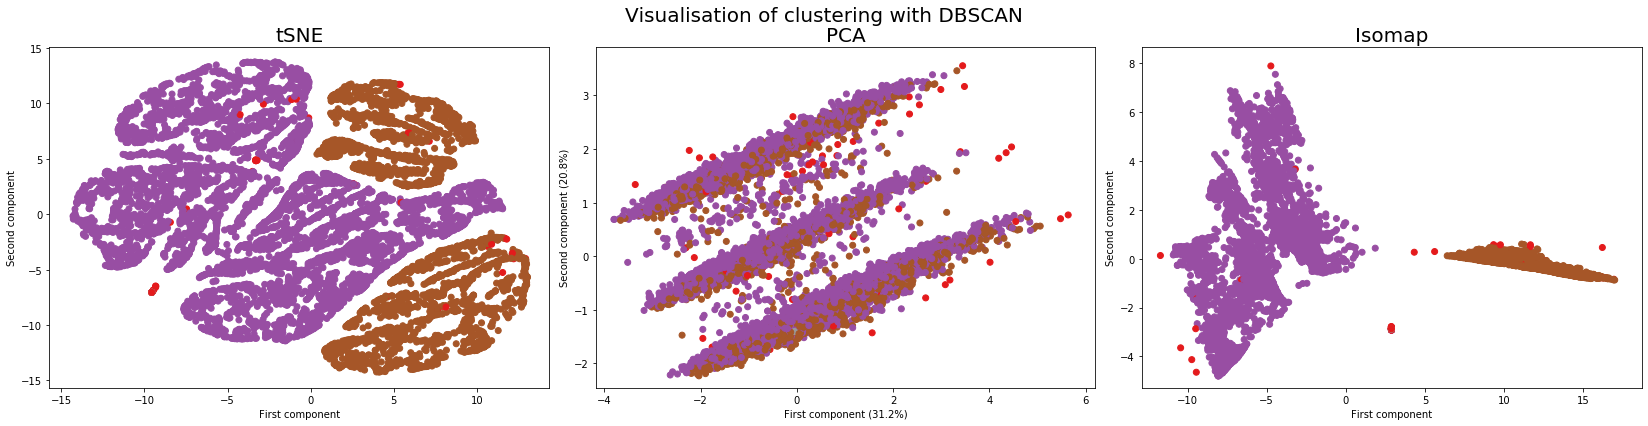

In [32]:
dbscan = cluster.DBSCAN(eps=1, min_samples=5, n_jobs=-1)
dbscan.fit(X_std)

# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

En jouant sur la valeur des hyper-paramètres eps et min_samples, nous pouvons modifier le nombre de classes trouvées par l'algorithme. Néanmoins, aucunes valeurs de ces hyper-paramètres ne permet de retrouver les 10 clusters du jeu de données initiales. Contrairement au k-means et au clustering hierarchique, DBSCAN ne permet pas de sélectionner le nombre de clusters.

### Réduction dimensionnelle (et visualisation)

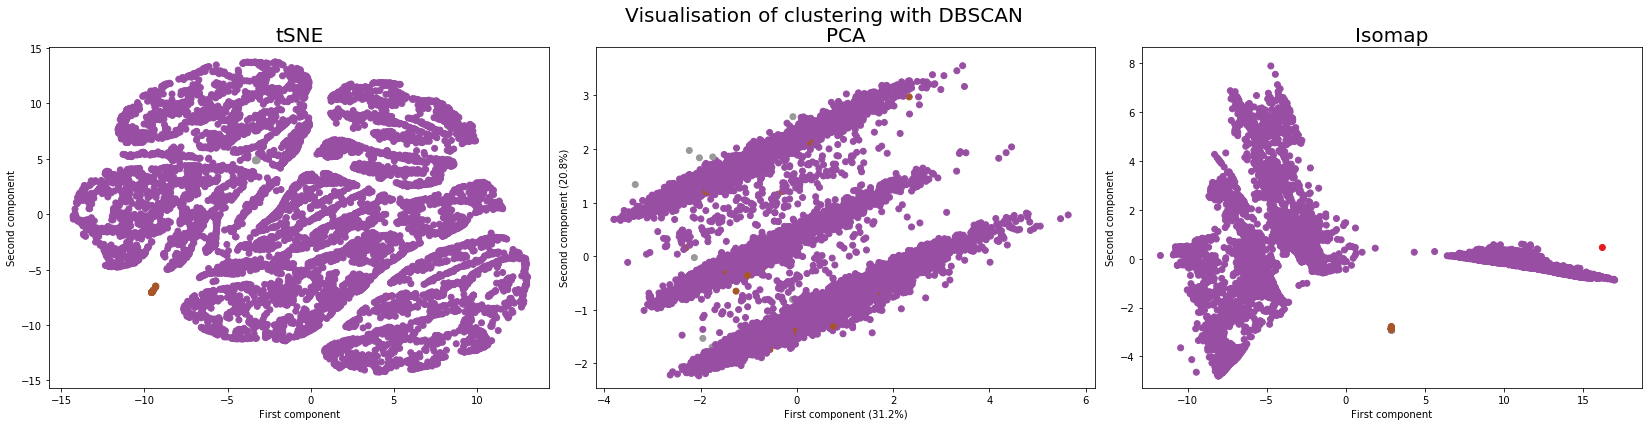

In [33]:
# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Répartition des effectifs par segments

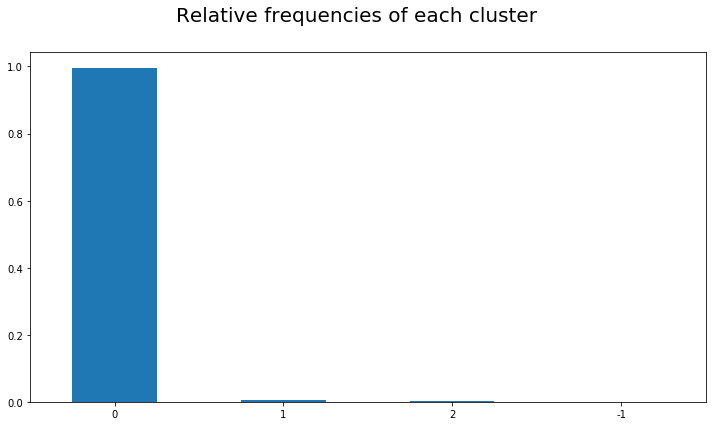

In [34]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Relative frequencies of each cluster', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
labels_counts = pd.Series(clusters_labels).value_counts() / len(clusters_labels)
labels_counts.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/clusters_frequencies.png');

### Évaluation de la partition

In [35]:
# Setup for call to the clustering_plots function
algorithm_name = 'DBSCAN'
standardized_features = X_std
clusters_labels = dbscan_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters (excluding noise): 3

Silhouette coefficient: s = 0.675
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.745
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.675259,0.7446
DBSCAN,3.0,0.675259,0.7446
k-means,6.0,0.227800,0.2425
Naïve model,2.0,0.000058,0.0007


## **OPTICS**


In [205]:
%%capture --no-stdout --no-display

# Definition of the search space for hyperparameters
param_grid = {
    'min_samples': [3, 5, 10], # number of neighbors to be considered as a core point
    'xi': [0.05, 0.1, 0.2], 
    'min_cluster_size': [0.01, 0.05],
}

# importing modules
from sklearn.cluster import OPTICS
from sklearn.metrics import silhouette_score

# instanciation of the GridSearch object
optics_search = GridSearch(
    estimator=OPTICS,
    param_grid=param_grid,
    scoring=silhouette_score,
)

# Proceeding the grid search
optics_search.fit(X_std)

# Displays best parameters
print("Best hyperparameters:", optics_search.best_params_)
print("Best Silhouette score:", optics_search.best_score_)

Best hyperparameters: {'min_cluster_size': 0.01, 'min_samples': 5, 'xi': 0.2}
Best Silhouette score: 0.20861229926946548


### Réduction dimensionnelle (et visualisation)

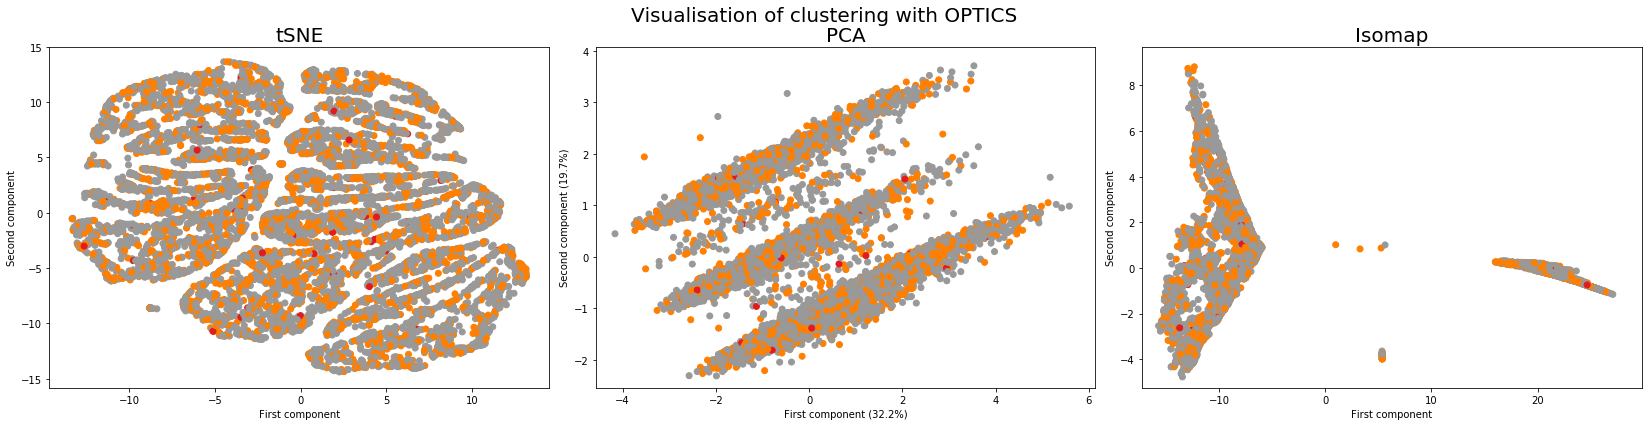

In [206]:
# Setup for call to the clustering_plots function
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

### Évaluation de la partition

In [207]:
# Setup for call to the clustering_plots function
algorithm_name = 'OPTICS'
standardized_features = X_std
clusters_labels = optics_search.best_estimator_.labels_

# Computes and displays results
metrics_clustering(algorithm_name, standardized_features, clusters_labels, results_df)

Estimated number of clusters (excluding noise): 2

Silhouette coefficient: s = 0.209
  Notice: values closer to 1 indicate a better partition

Gini coefficient: G = 0.345
  Notice: values closer to 0 indicate homogenic frequencies for clusters.



,Nb of clusters,Silhouette,Gini
hierarchical clustering,4.0,0.663266,0.742800
OPTICS,2.0,0.208612,0.344967
Naïve model,2.0,0.000180,0.000700


# **Profilage** des catégories de clients

## Récupération des informations

In [229]:
# Selecting the algorithm
#------------------------
# model = dbscan_search.best_estimator_ # DBSCAN gridsearch
# model = hierarchy_search.best_estimator_ # hierarchical clustering
# model = kmeans_search.best_estimator_ # k-means gridsearch
# model = kmeans # k-means 'handmade'
# model = dbscan # DBSCAN 'handmade'
model = optics_search.best_estimator_ # OPTICS gridsearch

In [230]:
# Getting the original standardized features for customers
standardized_features = pd.read_csv("data\cleaned\p5_data_std.csv")

# Re-fitting the algorithm
model.fit(X_std)
clusters_labels = model.labels_

# Creating a mask for the sample
mask = standardized_features.index.isin(X_std.index)

# Keeping data only for the sample
standardized_features = standardized_features[mask]

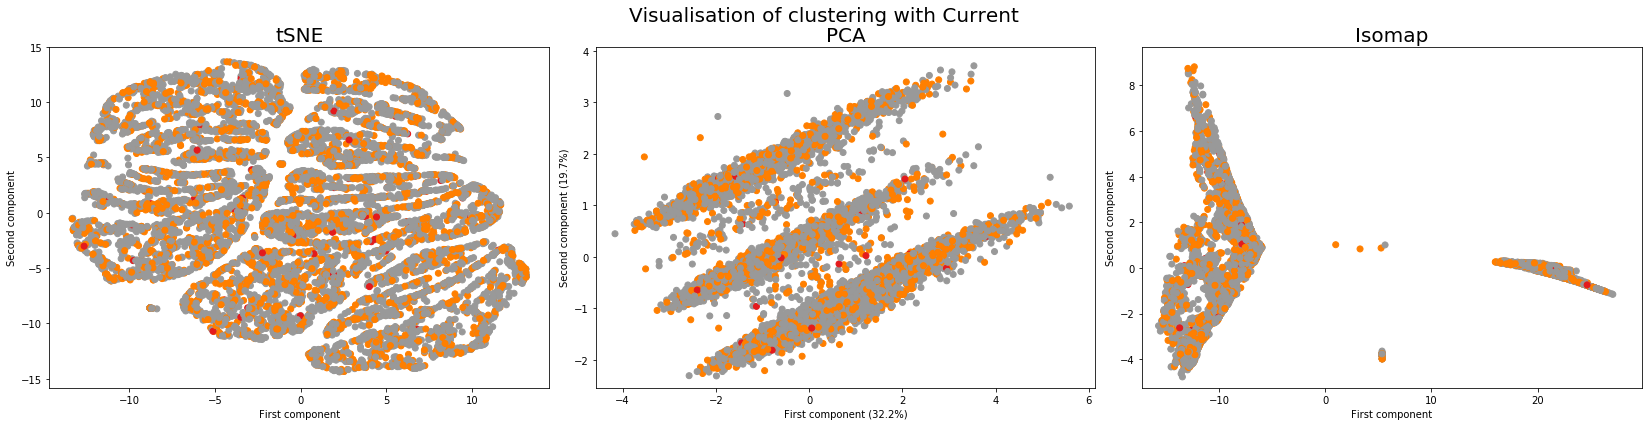

In [233]:
# Setup for call to the clustering_plots function
algorithm_name = 'Current'
standardized_features = X_std
clusters_labels = model.labels_

clustering_plots(algorithm_name, standardized_features, clusters_labels)

In [210]:
# Convert labels to pandas.DataFrame
clusters_labels = pd.Series(clusters_labels)
clusters_labels = clusters_labels.to_frame('cluster_labels')

# Get the list of clusters
list_clusters = clusters_labels['cluster_labels'].unique()
list_clusters.sort()

# Display frequencies for clusters
clusters_labels['cluster_labels'].value_counts(normalize=True, sort=False)

 0    0.3145
 1    0.6783
-1    0.0072
Name: cluster_labels, dtype: float64

## **Ré-échelonnage** des valeurs (0 à 100)

In [211]:
from sklearn.preprocessing import MinMaxScaler

# Rescale the features from 0 to 100
scaler = MinMaxScaler(feature_range=(0, 100))
scaled_features = scaler.fit_transform(standardized_features)

# Convert back to a pd.DataFrame
features_names = standardized_features.columns
scaled_features = pd.DataFrame(scaled_features, columns=features_names)

## **Significativité** des variables (méthode ANOVA)
Nous testons l'exitence d'une dépendance entre chacune des variables (considérées individuellements) et le groupe (variable qualitative).

Modèle de l'ANOVA : $ y_{i,j} = \mu + \alpha_i + \epsilon_{i,j}$

\begin{equation}
  \begin{cases}
    H_0 : \alpha_1 = … = \alpha_m = 0 \\
    H_1 : \exists i \in [1 ; m],  \alpha_i ≠ 0
  \end{cases}
\end{equation}

In [212]:
def get_significant_features(dataframe, categorical_labels, threshold=0.05):
    """This function proceed to a "1 variable - ANOVA" test 
    for each feature in the dataframe and returns a list
    of p-values for the Fischer statistic."""
    
    # load libraries
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    
    # categorical feature (labels) to test against
    clusters_labels = categorical_labels
    
    # initialize pd.DataFrame for results
    results_anova = pd.DataFrame()
    
    # create a pd.DataFrame with features and labels
    data_anova = pd.concat([dataframe, clusters_labels], axis=1)
    
    # iterating of features
    for feature_name in dataframe.columns:
        
        # create the model for the "1-variable ANOVA"
        formula = feature_name + "~" + "cluster_labels"
        anova_feature = smf.ols(formula, data=data_anova).fit()
        
        # get the p-value for the test statistic (Fisher)
        p_value = sm.stats.anova_lm(anova_feature, typ=2)['PR(>F)'][0]
        
        # Save the p-value for the test in a pd.DataFrame
        results_anova.loc[feature_name, 'p-value'] = p_value
        results_anova.loc[feature_name, 'significant'] = (p_value < threshold)
        
    # return pd.DataFrame of results
    return results_anova

In [213]:
# Setup before calling the function
dataframe = scaled_features
categorical_labels = clusters_labels

# Proceed to the "1 variable ANOVA test"
results_anova = get_significant_features(
    dataframe,
    categorical_labels,
    threshold=0.05
)

# Displays results of ANOVA analysis
display(results_anova)

# Get the significant features (above threshold)
threshold = 0.05
mask = (results_anova['p-value'] < threshold)
significant_features = results_anova[mask].index

,p-value,significant
mean_price_log,0.043458,True
mean_review_score,0.134286,False
mean_product_volume_log,0.014784,True
mean_product_weight_log,0.032239,True
cash_payment_percent,0.277794,False
credit_card_percent,0.943382,False
percentage_review,0.193876,False
region_Southeast,0.169742,False


## **Agrégation** des caractéristiques

In [214]:
# Get the name of features
features_names = scaled_features.columns

# Initializing a pd.DataFrame to store aggregate values
clusters_agg_df = pd.DataFrame(columns = [feature_name for feature_name in features_names])

# Iterating upon clusters
for cluster_index in list_clusters:
    
    # Getting elements of the cluster
    mask = (clusters_labels['cluster_labels'] == cluster_index)
    
    # For each feature. Could be vectorized.
    for feature in scaled_features.columns:
        # compute the mean
        mean_of_feature_for_cluster = scaled_features[mask][feature].mean()
        clusters_agg_df.loc[cluster_index, feature] = mean_of_feature_for_cluster
        # compute the standard deviation
        std_of_feature_for_cluster = scaled_features[mask][feature].std()
        clusters_agg_df.loc[cluster_index, feature+'_std'] = std_of_feature_for_cluster

# Compute the data for the 'mean customer'
for feature in scaled_features.columns:
    # compute the mean
    mean_of_feature = scaled_features[feature].mean()
    clusters_agg_df.loc['mean customer', feature] = mean_of_feature
    # compute the standard deviation
    std_of_feature = scaled_features[feature].std()
    clusters_agg_df.loc['mean customer', feature+'_std'] = std_of_feature
    # compute the standard deviation
    median_of_feature = scaled_features[feature].median()
    clusters_agg_df.loc['median customer', feature] = median_of_feature
    
clusters_agg_df.head(10)

,mean_price_log,mean_review_score,mean_product_volume_log,mean_product_weight_log,cash_payment_percent,credit_card_percent,percentage_review,region_Southeast,mean_price_log_std,mean_review_score_std,mean_product_volume_log_std,mean_product_weight_log_std,cash_payment_percent_std,credit_card_percent_std,percentage_review_std,region_Southeast_std
-1,33.4639,83.8542,41.6509,62.0814,50.6944,75.000000,32.8704,66.6667,12.914764,27.549371,19.277866,12.179439,49.995109,43.605142,3.928371,47.471266
0,33.7009,77.8567,43.9129,62.8717,49.0569,76.345472,33.1418,69.4118,13.325538,32.824250,18.986842,12.313581,49.487612,41.664573,3.117518,46.085342
1,34.2828,77.103,44.797,63.4119,47.9784,76.208559,33.2138,67.8756,13.656948,33.268682,18.985436,12.621519,49.448871,41.676440,3.029606,46.698881
mean customer,34.0939,77.3887,44.4963,63.2324,48.3371,76.242917,33.1887,68.35,13.549863,33.095364,18.992041,12.524017,49.462945,41.682735,3.064776,46.513373
median customer,33.0712,100,43.2229,61.774,0,100.000000,33.3333,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Séparer les données **catégorielles**

In [215]:
# Listing the categorical features encoded
categorical_features = [
        'season_spring',
        'season_winter',
        'season_summer',
        'season_automn',
        
        'main_cat_furniture',
        'main_cat_home',
        'main_cat_sports_leisure',
        'main_cat_electronics',
        'main_cat_fashion',
        'main_cat_supplies',
        'main_cat_health_beauty',
        'main_cat_construction',
        'main_cat_misc',
        'main_cat_gifts',
        'main_cat_food_drink',
]

# Masking columns based on their name
mask = clusters_agg_df.columns.isin(categorical_features)
data_kiviat = clusters_agg_df.loc[:, ~mask]
numerical_features = set(features_names) - set(categorical_features)

### **Diagrammes** de Kiviat 

In [216]:
def kiviat_diagram(cluster_index):

    # Get features names
    features_names = list(numerical_features)

    # Get number of variables
    num_vars = len(features_names)


    # Split the circle into even parts and save the angles
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    
    # Set color
    #----------
    #cmap = plt.cm.Dark2  # ListedColormap
    cmap = plt.cm.get_cmap('hsv')  # LinearSegmentedColormap
    NB_CLUSTERS = len(list_clusters) - (1 if -1 in clusters_labels else 0)
    color = cmap(cluster_index/NB_CLUSTERS)
  
    # Add cluster to the chart
    #-------------------------
    # Get values and complete the circle
    values = data_kiviat[features_names].loc[cluster_index].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, label="Cluster #"+str(cluster_index))
    ax.fill(angles, values, color=color, alpha=0.25)

    # add_to_radar(1, '#429bf4')
    # add_to_radar('mean customer', '#d42cea')

    # Add 'mean customer' to the chart
    # Get values and complete the circle
    values = data_kiviat[features_names].loc['mean customer'].tolist()
    values += values[:1]
    ax.plot(angles, values, color='black', linewidth=0.6, label='mean customer')
    # ax.fill(angles, values, color=color, alpha=0.25)

    # Fix axis to go in the right order and start at 12 o'clock.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axis lines for each angle and label.
    ax.set_thetagrids(np.degrees(angles), features_names)

    # Go through labels and adjust alignment based on position
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    # Ensure radar goes from 0 to 100
    ax.set_ylim(0, 100)

    # Set position of y-labels (0-100)
    ax.set_rlabel_position(180 / num_vars)

    # Add some custom styling.
    # Change the color of the tick labels.
    ax.tick_params(colors='#222222')
    # Make the y-axis (0-100) labels smaller.
    ax.tick_params(axis='y', labelsize=8)
    # Change the color of the circular gridlines.
    ax.grid(color='#AAAAAA')
    # Change the color of the outermost gridline (the spine).
    ax.spines['polar'].set_color('#222222')
    # Change the background color inside the circle itself.
    ax.set_facecolor('#FAFAFA')

    # Add title
    ax.set_title('Cluster #{} profile'.format(cluster_index), y=1.08)

    # Add a legend
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1));

    fig.savefig('plots/kiviat_cluster{}.png'.format(cluster_index));

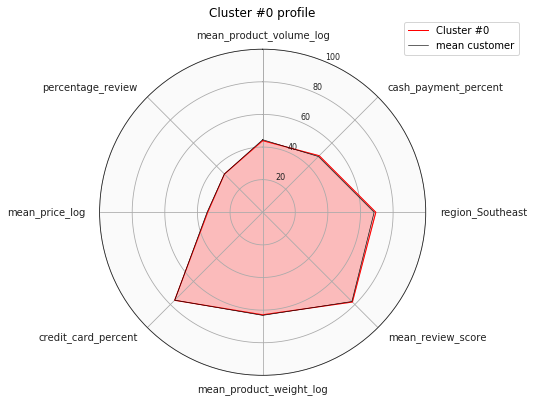

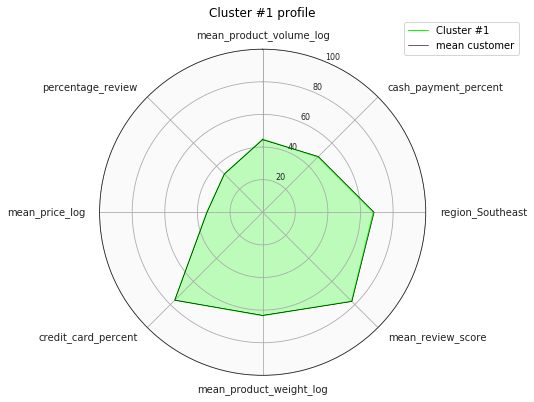

In [217]:
# Draw Kiviat diagrams for each cluster
for cluster_index in list_clusters:
    # don't draw cluster_index for noise
    if cluster_index == -1:
        continue
    kiviat_diagram(cluster_index)

### Axe for each cluster

In [ ]:
kiviat_axes(cluster_idx=1)

## Axe pour les variables catégorielles

In [ ]:
def barplot_axes(cluster_idx, ax=None):
    
    # If no axes is passed…
    if not ax:
        # Set the axes to the current one
        ax = plt.gca() # ax = ax or plt.gca() # 'a or b' instruction returns first True value   
        # Set dimensions of the figure (if no axes is passed)
        plt.gcf().set_figwidth(15)
        plt.gcf().set_figheight(5)
   
    # Set the data
    labels = categorical_features
    cluster_means = clusters_agg_df[categorical_features].loc[cluster_idx].tolist()
    # cluster_std = clusters_agg_df[categorical_features].loc[cluster_idx].tolist()
    global_means = clusters_agg_df[categorical_features].loc['mean customer'].tolist()
    # global_std = clusters_agg_df[categorical_features].loc['mean customer'].tolist()

    # Set position of the bars
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    # Plot the axe (optionnaly, with errorbars)
    rects1 = ax.bar(x - width/2, cluster_means, width, label='Cluster #{}'.format(cluster_idx)) # yerr=cluster_std
    rects2 = ax.bar(x + width/2, global_means, width, label='Mean') #yerr=global_std
    
    # Properties of the axes
    ax.set_xticks(x) # positions of the ticks
    ax.set_xticklabels(labels) # labels of the ticks
    ax.set_title('Cluster profile')
    ax.set_xlabel('categorial feature')
    ax.set_ylabel('ylabel')
    ax.legend()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Men')
rects2 = ax.bar(x + width/2, women_means, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')




def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

# **Analyse** des résultats

## **Qualité** des partitions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Performance of models\n', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Silhouette'].sort_values(ascending=False).T.plot.bar(ax=ax1)

# Rotation of ticks labels
# plt.setp(ax1.get_xticklabels(), rotation='horizontal')
ax1.set_title("Silhouette score")

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.96])

fig.savefig('plots/metrics.png');

## **Nombre de clusters** optimal avec chaque algorithme

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Optimal number of clusters \n (based on silhouette score)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Nb of clusters'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/nb_clusters.png');

## **Homogénéité** des effectifs des groupes

### Coefficient de Gini de la partition

Coefficient de Gini : $ G = \frac{MAD}{2·\overline{n_k}} $
* effectif moyen des groupes : $\overline{n_k} = \frac{1}{K} \sum\limits_{k=1}^K |C_k| = \frac{n}{K}$
* différence absolue moyenne des effectifs : $ MAD = \frac{1}{K^2} \sum\limits_{k_1=1}^K \sum\limits_{k_2=1}^K ||C_{k_1}| - |C_{k_2}||$

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure()

# Set properties of the figure
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle("Gini coefficient of clusters' frequencies \n(Smaller value means more homogenic size for clusters)", fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Gini'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/gini.png');

## **Temps** de calcul

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Adding the training time to the results DataFrame
results_df.loc['hierarchical clustering', 'Training time (s)'] = hierarchy_search.refit_time_
results_df.loc['k-means', 'Training time (s)'] = kmeans_search.refit_time_
results_df.loc['DBSCAN', 'Training time (s)'] = dbscan_search.refit_time_

# Set properties of the figure
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(10)
fig.suptitle('Training time (s)', fontsize=20)

# Set the geometry of the grid of subplots
gs = gridspec.GridSpec(nrows=1, ncols=1,)

# Initialize axes and set position (left to right, top to bottom)
# Use sharex or sharey parameter for sharing axis
ax1 = fig.add_subplot(gs[0])

# Filling the axes
results_df['Training time (s)'].T.plot.bar(ax=ax1)

# Rotation of ticks labels
plt.setp(ax1.get_xticklabels(), rotation='horizontal')

# Automatically adjusts subplots params to fit the figure
gs.tight_layout(fig, rect=[0, 0, 1, 0.9])

fig.savefig('plots/training_time.png');

## **Stabilité à l'initialisation** de la partition

### **Indice de Rand Ajusté** (ARI)
L'*Adjusted Rand Index* (ARI) est la normalisation de l'indice de Rand (RI) qui permet de comparer deux partitions de nombres de classes différentes.

$ ARI = \frac{RI-E(RI)}{max(RI)-E(RI)}$
* RI : indice de Rand, proportion de paires de points qui sont groupés de la même façon dans les deux partitions.
* E(RI) : espérance de l'indice de Rand (pour une partition aléatoire)
* max(RI) : indice de Rand maximal qui pourrait être obtenu étant donné le nombre de classes distincts

### Calcul de la métrique de stabilité

In [258]:
def initialisation_stability(model, nb_iter=5):

    from sklearn.metrics.cluster import adjusted_rand_score
    import statistics

    # Creating randomly initialized partitions for comparison
    #--------------------------------------------------------

    # Initializing the list of partitions
    partitions = []
    
    # Iterating
    for i in range(nb_iter):

        # Instanciation of the model
        # model = estimator()

        # Fitting the model
        model.fit(X_std)

        # Getting the results (labels of points)
        partitions.append(model.labels_)


    # Computing the ARI scores between partitions
    #--------------------------------------------------------

    # Initializing list of ARI scores
    ARI_scores = []

    # For each partition, except last one
    for i in range(nb_iter-1):
        # Compute the ARI score with other partitions
        for j in range(i+1, nb_iter):
            ARI_score = adjusted_rand_score(partitions[i], partitions[j])
            ARI_scores.append(ARI_score)

    # Compute the mean and standard deviation of ARI scores
    ARI_mean = statistics.mean(ARI_scores)
    ARI_std = statistics.stdev(ARI_scores)

    # Display results
    print("Evaluation of stability upon random initialization: {:.1f}%  ± {:.1f}% ".format(100*ARI_mean, 100*ARI_std))

    return ARI_scores

# Computing the metric of stability
stability_hierarchy = initialisation_stability(model=hierarchy_search.best_estimator_)
stability_kmeans = initialisation_stability(model=kmeans_search.best_estimator_)
stability_dbscan = initialisation_stability(model=dbscan_search.best_estimator_)

Evaluation of stability upon random initialization: 100.0%  ± 0.0% 
Evaluation of stability upon random initialization: 49.4%  ± 7.3% 
Evaluation of stability upon random initialization: 100.0%  ± 0.0% 


### Visualisation

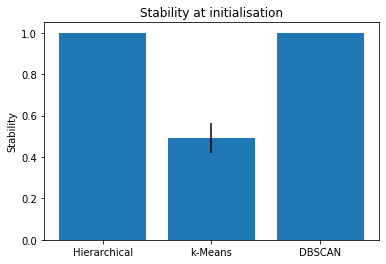

In [259]:
import statistics

means = [
    statistics.mean(stability_hierarchy),
    statistics.mean(stability_kmeans),
    statistics.mean(stability_dbscan),
        ]

std_errors = [
    statistics.stdev(stability_hierarchy),
    statistics.stdev(stability_kmeans),
    statistics.stdev(stability_dbscan),
]

import numpy as np
import matplotlib.pyplot as plt

ind = np.arange(3)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

plt.bar(ind, means, yerr=std_errors)

plt.ylabel('Stability')
plt.title('Stability at initialisation')
plt.xticks(ind, ('Hierarchical', 'k-Means', 'DBSCAN'))

plt.show()

# **Stabilité temporelle** de la segmentation

## **Protocole**

1. fitter l'algorithme de clustering sur une première fraction du jeu de données
2. utiliser la méthode predict sur ce premier lot ; la ségmentation obtenue servira de référence
3. refitter l'algorithme en ajoutant aux données une fraction supplémentaire
4. Utiliser à nouveau la methode predict sur l'échantillon de départ
5. Calculer l'ARI entre la partition initiale et la nouvelle partition

## **Importation** des données clients avec *timestamp*

In [262]:
# Get initial data about customers
data_customers = pd.read_csv("data\cleaned\p5_data_PCA.csv")

# Get the data about customers, before PCA
data_encoded = pd.read_csv("data\cleaned\p5_data_encoded.csv")

# Get the 'timestamps' of orders
data_timestamps = pd.to_datetime(data_encoded['last_order_purchase_timestamp'])

In [263]:
# Get main temporal informations from data set
date_min = data_timestamps.min()
date_max = data_timestamps.max()
duration = date_max - date_min

print('The data set covers a period of {} days, from {} to {}.'.format(duration.days, date_min.date(), date_max.date()))

The data set covers a period of 728 days, from 2016-09-04 to 2018-09-03.


## Évaluation de la stabilité temporelle

In [279]:
def time_stability(model, nb_iter=5):

    from datetime import datetime, timedelta
    from sklearn.metrics.cluster import adjusted_rand_score
    from sklearn import cluster

    # Setting the initial data set to one year of data
    date_init = date_min + timedelta(days=365)

    # Getting the initial data set
    timemask = (data_timestamps < date_init)
    X_init = data_customers[timemask]
    print("Number of customers in the initial data:", len(X_init))

    # Standardization and PCA of the dataset...
    X_init_std = X_init

    # Fitting the model on intial data
    model.fit(X_init_std)

    # Predicting the initial clusters labels for initial customers
    # clusters_init = model.predict(X_init_std)
    clusters_init = model.labels_

    # Initializations
    ARI_results = pd.DataFrame()
    index = -1
    date_lim = date_init

    # Iterating until we reach the maximum date in data set
    while date_lim < date_max:
        index +=1
        # getting the new data truncated
        timemask = (data_timestamps < date_lim)
        X_trunc = data_customers[timemask]
        # standardisation and PCA
        X_trunc_std = X_trunc

        # iterating for stability and standard deviation of scores
        #--------------------------------------------------------
        ARI_scores = []

        for i in range(nb_iter):

            # fitting a new model on the truncated data
            model.fit(X_trunc_std)

            # Creating a mask for customers in initial partition
            mask = X_trunc_std.index.isin(X_init_std.index)

            # Getting the labels for the initial customers
            clusters_new = pd.Series(model.labels_)[mask]
            # clusters_new = model.predict(X_init_std)

            # Computing and saving ARI score between initial clustering and new ones
            ARI_score = adjusted_rand_score(clusters_init, clusters_new)
            ARI_scores.append(ARI_score)

            # Add timestamp and ARI scores to the results pd.DataFrame
            ARI_results.loc[index, 'period'] = date_lim - date_init
            ARI_results.loc[index, 'ARI_score_mean'] =  np.mean(ARI_scores)
            ARI_results.loc[index, 'ARI_score_std'] =  np.std(ARI_scores)

        # increase timelimit by 30 days for next iteration
        date_lim += timedelta(days=30)

    return ARI_results

In [ ]:
hierarchy_stability = time_stability(model=hierarchy_search.best_estimator_)

In [ ]:
kmeans_stability = time_stability(model=kmeans_search.best_estimator_)

In [ ]:
dbscan_stability = time_stability(model=dbscan_search.best_estimator_)

Number of customers in the initial data: 22904


In [ ]:
hierarchy_stability

## **Visualisation** de l'évolution du modèle de partitionnement

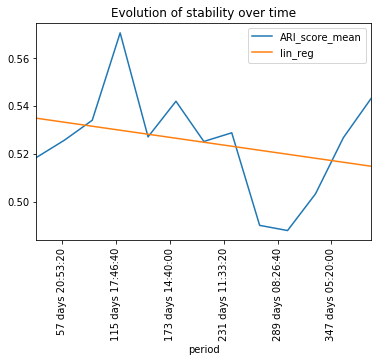

In [266]:
# Linear regression
x_scal = np.arange(ARI_results['period'].size) # = array([0, 1, 2, ..., 3598, 3599, 3600])
fit = np.polyfit(x_scal, ARI_results['ARI_score_mean'], 1)
fit_fn = np.poly1d(fit)
ARI_results['lin_reg'] = fit_fn(x_scal)

# Ploting the ARI_score and linear regression
ARI_results[['period', 'ARI_score_mean', 'lin_reg']].plot(x='period', rot=90, title="Evolution of stability over time") ;

# Autre

## TO-DO LIST

* Description "actionnable" : 
    * après segmentation, description des segments (clusters). Ex : type de produit, quantité de produit…
    * Diagrammes RADAR pour les clusters avec les variables + écart-type
    * pour les variables catégorielles (catégorie, état, paiement...), trouver un autre mode de représentation : double bar chart.
    * Récupérer les données : quantitatives (pour Kiviat), et catégorielles (pour diagramme)
    * Diagrammes de Kiviat : sélectionner les features significatives pour LE cluster considéré

* Autres
    * Heatmap des hyperparamètres de DBSCAN : intégrer le nombre de clusters
    * Automatiser la heatmap à partir d'une grid search
    * Essayer k-mode et/ou k-prototype

## **AMELIORATIONS POSSIBLES**
* Créer une fonction customisée pour calculer la distance entre deux points. Les méthodes de clustering se basent sur la notion de distance… Attention : distance euclidienne ok pour les variables numériques, mais pas adapté pour les variables catégorielles et booléennes
* Stabilité : injection de bruit ou modification de paramètres avant de relancer (non implémenté sous sklearn)
* Stabilité : fiabiliser le processus : sélectionner uniquement les données (data_items) disponibles à une date donnée et refaire la compilation des données clients à partir de cela ; inclure ACP et standardisation
* Voir avec Scipy pour combinaison aléatoire à partir de la distribution pour RandomizedSearch
* Mettre en place une méthode de "Consensus Clustering"
* Autres algorithmes :
    * k-means (k-means++, avec et sans noyau)
    * Expectation–Maximization (EM)
    * Clustering using Gaussian Mixture Models (GMM)
    * Mean-Shift Clustering
    * OPTICS (https://scikit-learn.org/stable/modules/clustering.html)